# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=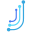)](https://jvelezmagic.com/)

![Curso de Manejo de Datos Faltantes: Exploración](course-logo.jpg)

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [1]:
!pip install -r requirements.txt

  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached ipywidgets-8.1.2-py3-none-any.whl.metadata (2.4 kB)
  Using cached ozon3-4.0.2-py3-none-any.whl.metadata (8.2 kB)
  Using cached statsmodels-0.13.2.tar.gz (17.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [151 lines of output]
      <string>:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      <string>:218: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more de

In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [3]:
%run pandas-missing-extension.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [4]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [5]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

/home/alphalejo/anaconda3/envs/missing_values/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [6]:
(
    smf.ols(
        formula="temp ~ ozone",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Wed, 10 Apr 2024",Prob (F-statistic):,2.93e-18
Time:,21:21:24,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [7]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Wed, 10 Apr 2024",Prob (F-statistic):,1.47e-16
Time:,21:21:24,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [8]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [9]:
# Aquí tu código...
smf.ols(
    formula="death ~ C(chapter)",
    data=survival_df
).fit().summary().tables[0]

/home/alphalejo/anaconda3/envs/missing_values/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-143.5
Date:,"Wed, 10 Apr 2024",Prob (F-statistic):,1.00
Time:,21:21:24,Log-Likelihood:,66256.
No. Observations:,2169,AIC:,-1.325e+05
Df Residuals:,2153,BIC:,-1.324e+05
Df Model:,15,,
Covariance Type:,nonrobust,,


## Preparando datos: _National Health and Nutrition Examination Survey_

/home/alphalejo/anaconda3/envs/missing_values/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


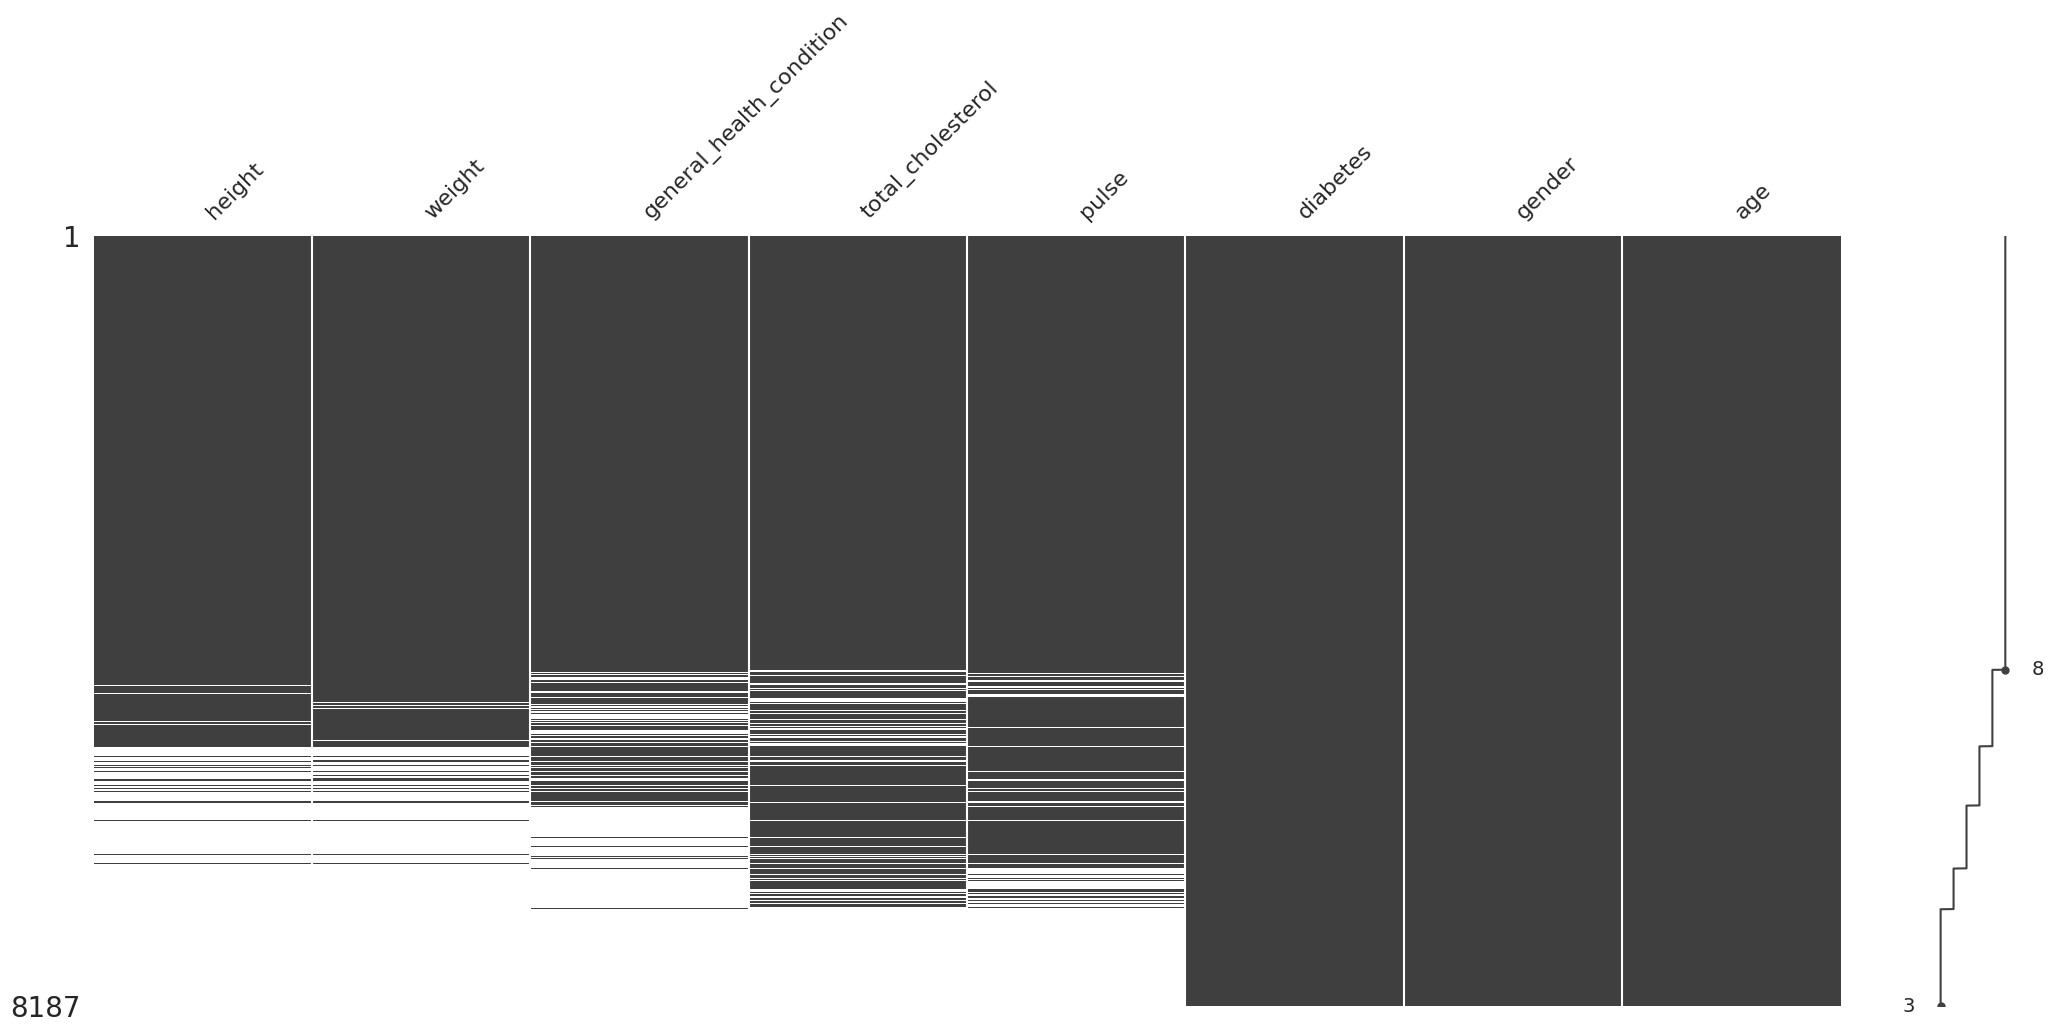

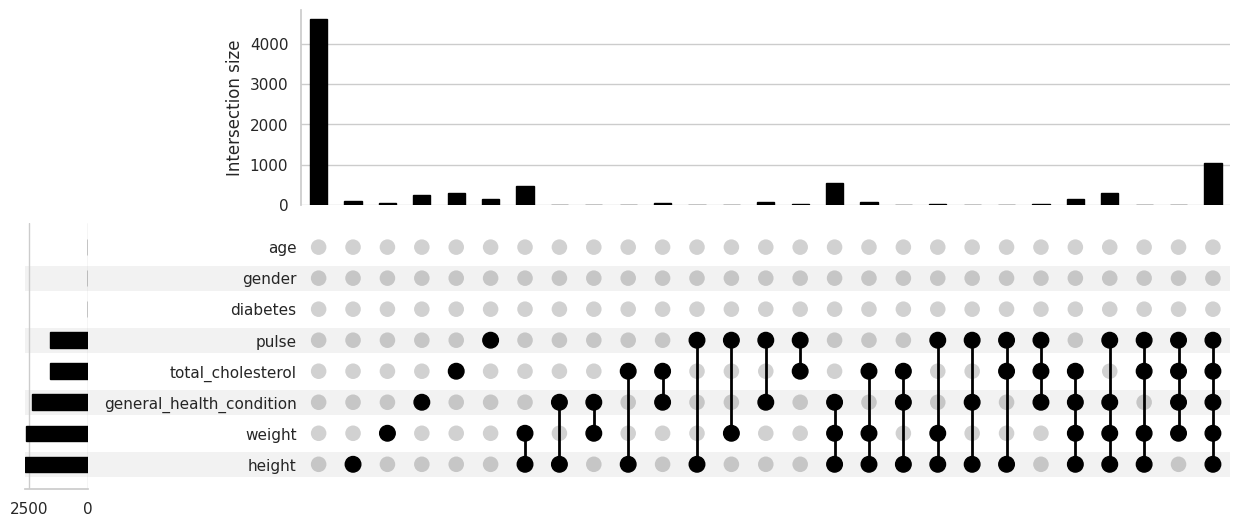

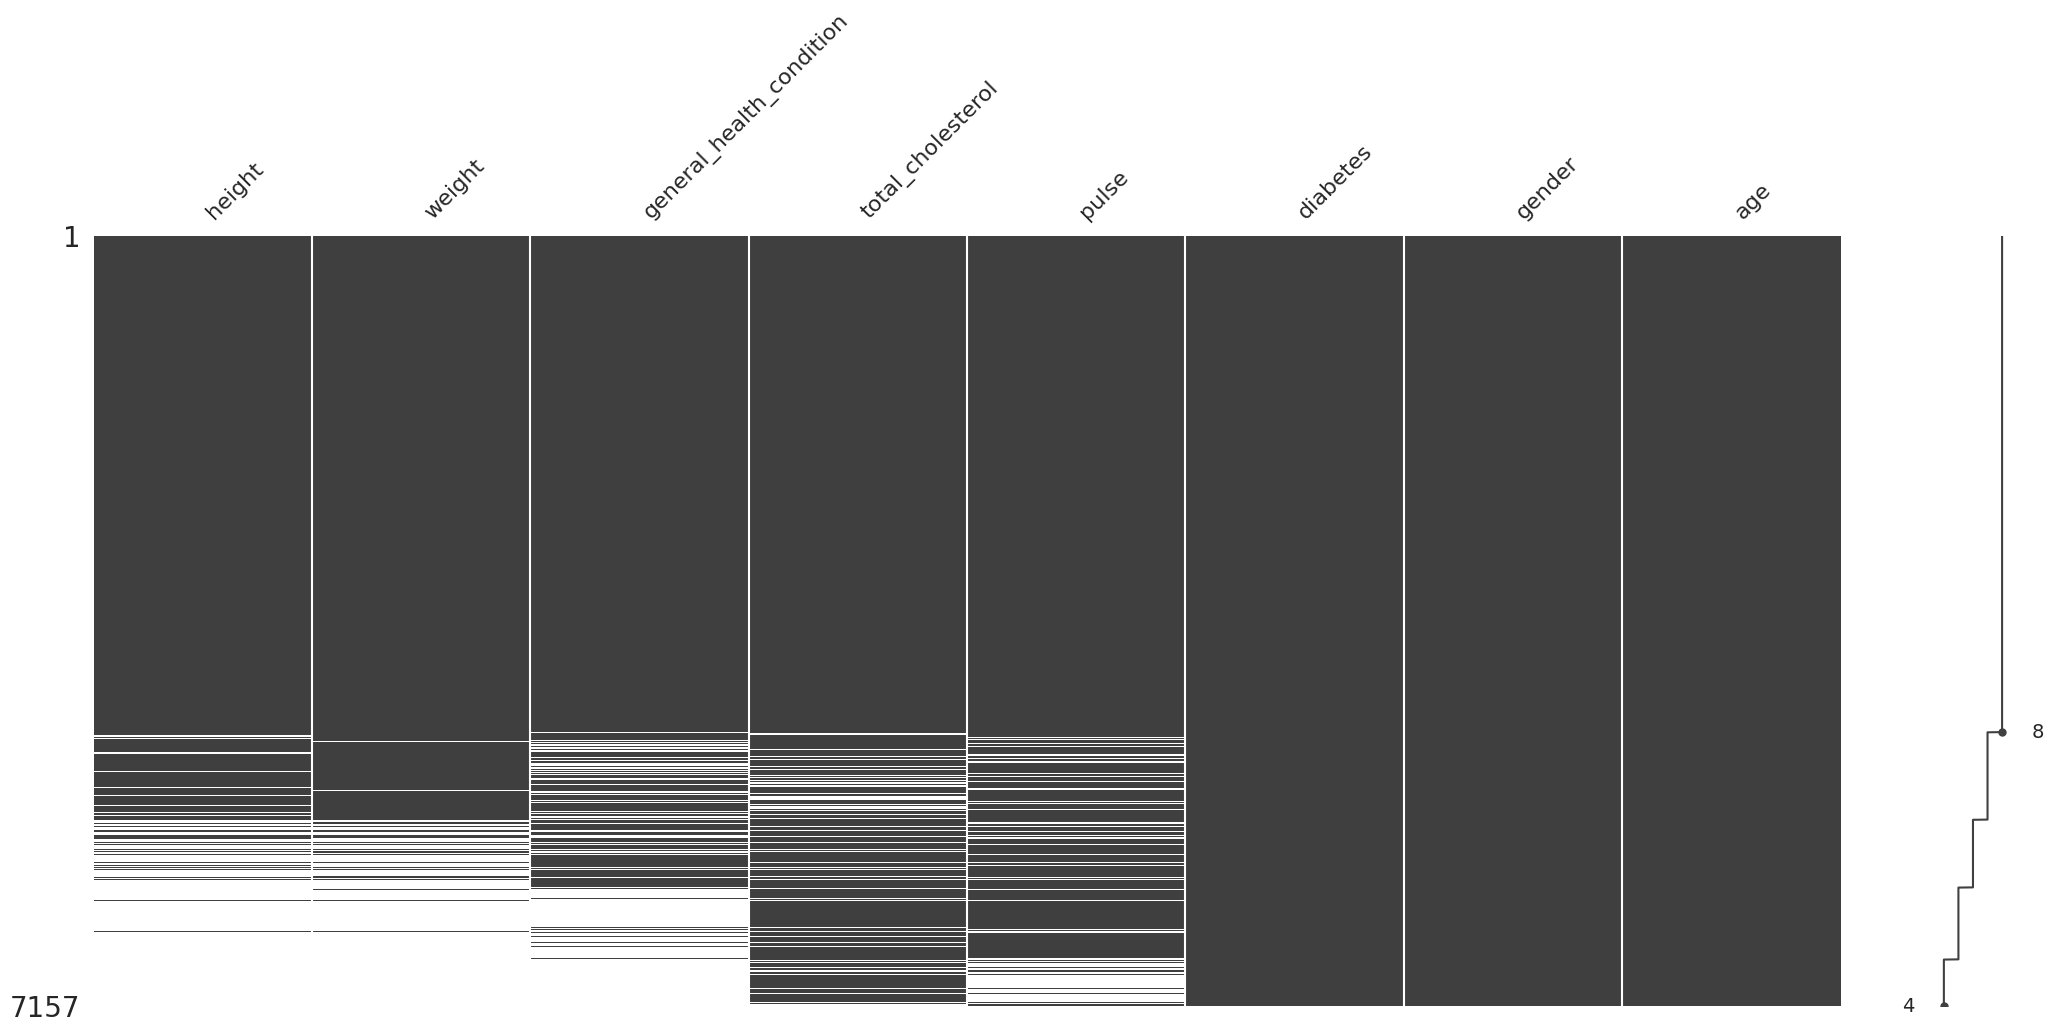

In [10]:
%run download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [11]:
# Split the weight data into two groups based on gender
female_weight, male_weight = (
    # Start with the DataFrame
    nhanes_df
    # Select only the columns of interest
    .select_columns("gender", "weight")
    # Transform the weight column by replacing NaN values with False
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise = False
    )
    # Group the data by gender
    .groupby("gender")
    # Select the weight column
    .weight
    # Use the pipe function to apply a lambda function to the grouped data
    .pipe(
        lambda df: (
            # Get the weight data for females
            df.get_group("Female"),
            # Get the weight data for males
            df.get_group("Male")
        )
    )
)

# Perform a two-sided t-test to compare the weights of females and males
t_test_result = scipy.stats.ttest_ind(
    a= female_weight,
    b = male_weight,
    alternative= "two-sided"
)
t_test_result

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

## Amplía tu conjunto de herramientas para explorar valores faltantes

(<Figure size 1000x1000 with 3 Axes>,
 {('Female', 'Excellent', '!NA'): (0.0,
   0.0,
   0.38910692830200494,
   0.0743407957417306),
  ('Female', 'Excellent', 'NA'): (0.3902367251483326,
   0.0,
   0.11930165254542605,
   0.0743407957417306),
  ('Female', 'Fair or', '!NA'): (0.0,
   0.07761948426632075,
   0.47227802180243583,
   0.15861158947062376),
  ('Female', 'Fair or', 'NA'): (0.4734078186487635,
   0.07761948426632075,
   0.036130559044995084,
   0.15861158947062376),
  ('Female', 'Good', '!NA'): (0.0,
   0.23950976226153467,
   0.4611244906122378,
   0.3260796636325006),
  ('Female', 'Good', 'NA'): (0.4622542874585654,
   0.23950976226153467,
   0.04728409023519317,
   0.3260796636325006),
  ('Female', 'Poor?', '!NA'): (0.0,
   0.5688681144186255,
   0.4926846041201908,
   0.0260326974258046),
  ('Female', 'Poor?', 'NA'): (0.49381440096651846,
   0.5688681144186255,
   0.015723976727240133,
   0.0260326974258046),
  ('Female', 'Very good', '!NA'): (0.0,
   0.5981795003690202,


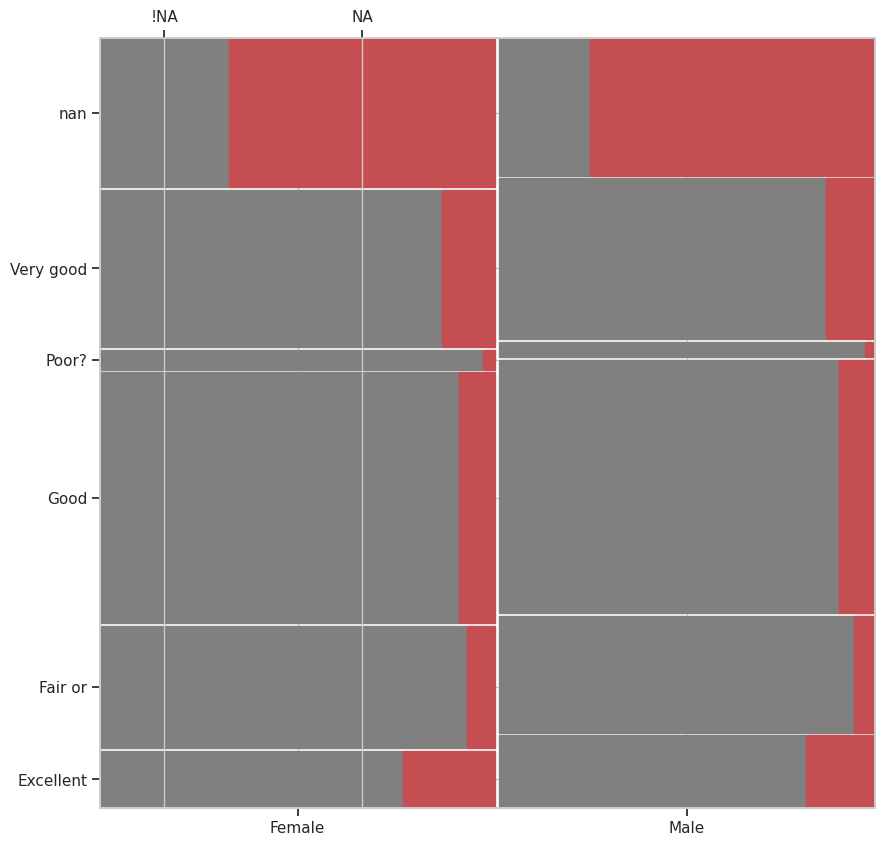

In [12]:
# Create a new figure and axes with a specified size
fig, ax = plt.subplots(figsize=(10,10))

# Perform several operations on the DataFrame
(
    nhanes_df
    # Select only the columns of interest
    .select_columns("weight", "general_health_condition", "gender")
    # Replace NaN values in the weight column with "NA", and non-NaN values with "!NA"
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])
    )
    # Group the data by gender, general health condition, and weight (either "NA" or "!NA")
    .groupby(
        ["gender","general_health_condition", "weight"],
        dropna=False,
        as_index = True
    )
    # Get the size of each group
    .size()
    # Use the pipe function to apply a lambda function to the grouped data
    .pipe(
        lambda df: mosaic(
            # The data to be used for the mosaic plot
            data= df,
            # The properties of each tile in the mosaic plot
            properties= lambda key: {"color":"r" if "NA" in key else "gray"},
            # Whether the plot should be horizontal
            horizontal= True,
            # Whether to label the axes
            axes_label=True,
            # The title of the plot
            title="",
            # The labels for the tiles
            labelizer= lambda key: "",
            # The axes object to draw the plot on
            ax = ax
        )
    )
)


## Tratamiento de variables categóricas para imputación de valores faltantes

In [13]:
nhanes_transform_df = nhanes_df.copy(deep = True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [14]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [15]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [16]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [17]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [18]:
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns

In [19]:
sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
    )

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [20]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
    )

In [21]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index= nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

/home/alphalejo/anaconda3/envs/missing_values/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


In [22]:
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


### _One Hot Encoding_

In [23]:
nhanes_transform_df_2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [24]:
(
    nhanes_transform_df_2
    .select_columns("general_health_condition")
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
93709.0,False,False,False,False,False
93711.0,False,False,False,False,True
...,...,...,...,...,...
102949.0,True,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


#### `skelearn.preprocessing.OneHotEncoder()`

In [25]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [26]:
nhanes_transformed_df_2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index= nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
)
nhanes_transformed_df_2

/home/alphalejo/anaconda3/envs/missing_values/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [27]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [28]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0,0,1,0,0,0]]
    )
)

array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

In [29]:
(
    nhanes_df
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
    .height
    .mean()
)

66.25655976676386

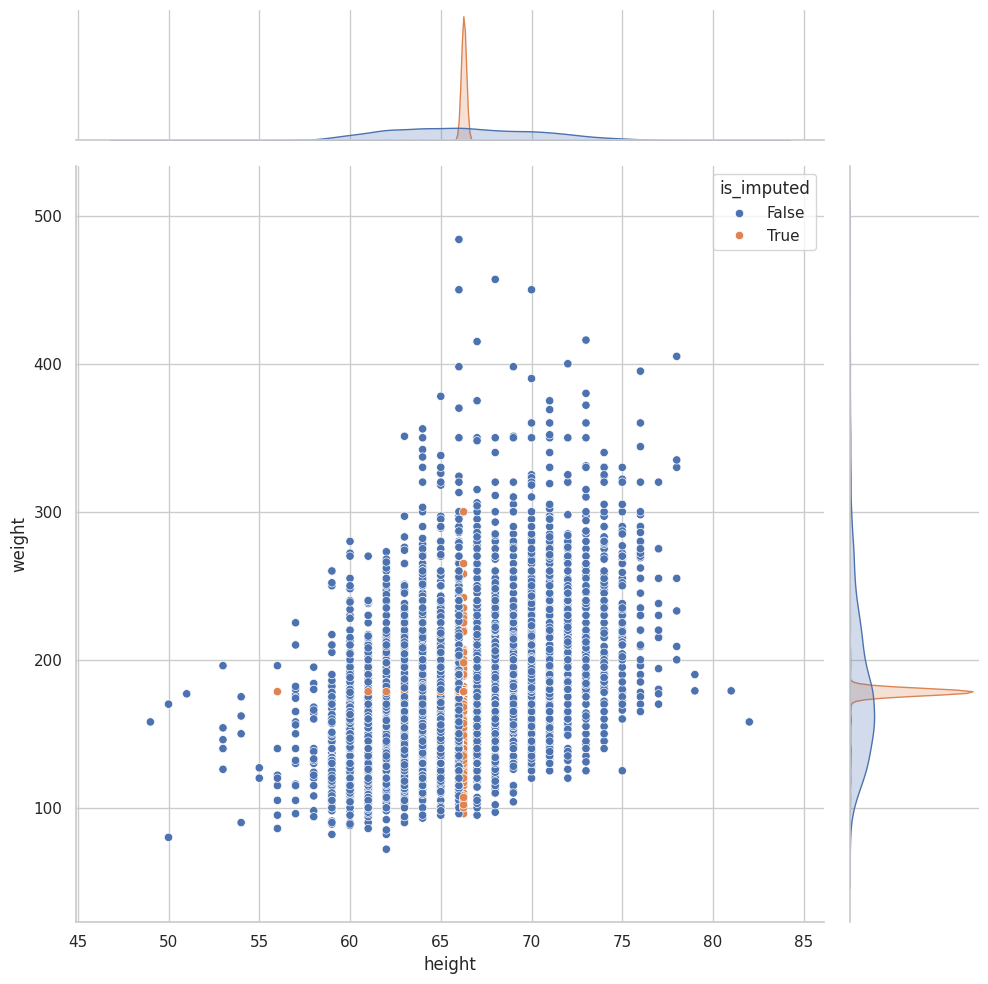

In [30]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal = True,
        height = 10
    )
)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

In [36]:
(
    nhanes_df
    .select_columns("height","weight")
    #.fillna(method = "ffill")
    .ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [37]:
(
    nhanes_df
    .select_columns("height","weight")
    #.fillna(method = "bfill")
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [39]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,NaN,NaN,Good,189.0,100.0,0,Male,13.0
93709.0,62.0,200.0,NaN,176.0,74.0,0,Female,75.0
93711.0,69.0,142.0,Very good,238.0,62.0,0,Male,56.0
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,Male,33.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


In [42]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,56.0,115.0,Female,0,Excellent
94187.0,59.0,130.0,Female,0,Excellent
95289.0,59.0,162.0,Female,0,Excellent
97967.0,59.0,130.0,Female,0,Excellent
99125.0,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96954.0,NaN,175.0,Male,1,NaN
97267.0,NaN,175.0,Male,1,NaN


In [48]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .groupby(
        by = ["gender", "diabetes", "general_health_condition", "height"],
    )
    .apply(
        lambda df: df["weight"].ffill()
    )
)

gender  diabetes  general_health_condition  height  SEQN    
Female  0         Excellent                 56.0    94421.0     115.0
                                            59.0    94187.0     130.0
                                                    95289.0     162.0
                                                    97967.0     130.0
                                                    99125.0     105.0
                                                                ...  
Male    1         Very good                 74.0    100617.0    215.0
                                            75.0    94093.0     268.0
                                                    95553.0     225.0
                                                    101046.0    219.0
                                            82.0    99068.0     158.0
Name: weight, Length: 5112, dtype: float64

## Imputación por interpolación

<Axes: xlabel='date'>

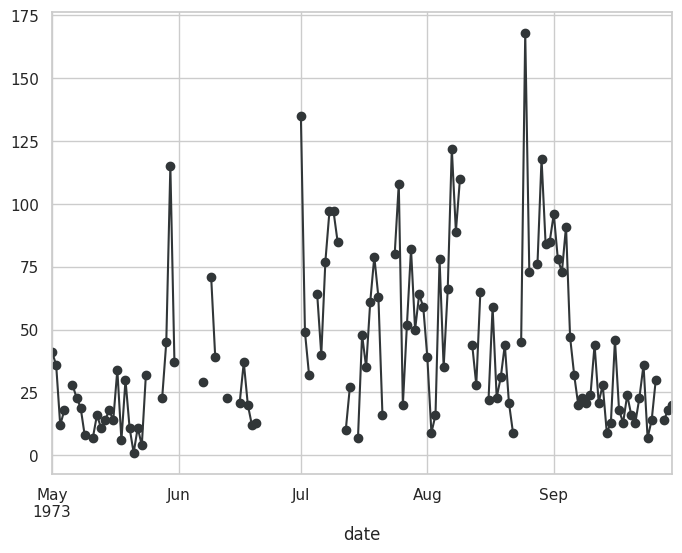

In [49]:
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.plot(color="#313638", marker= "o")
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

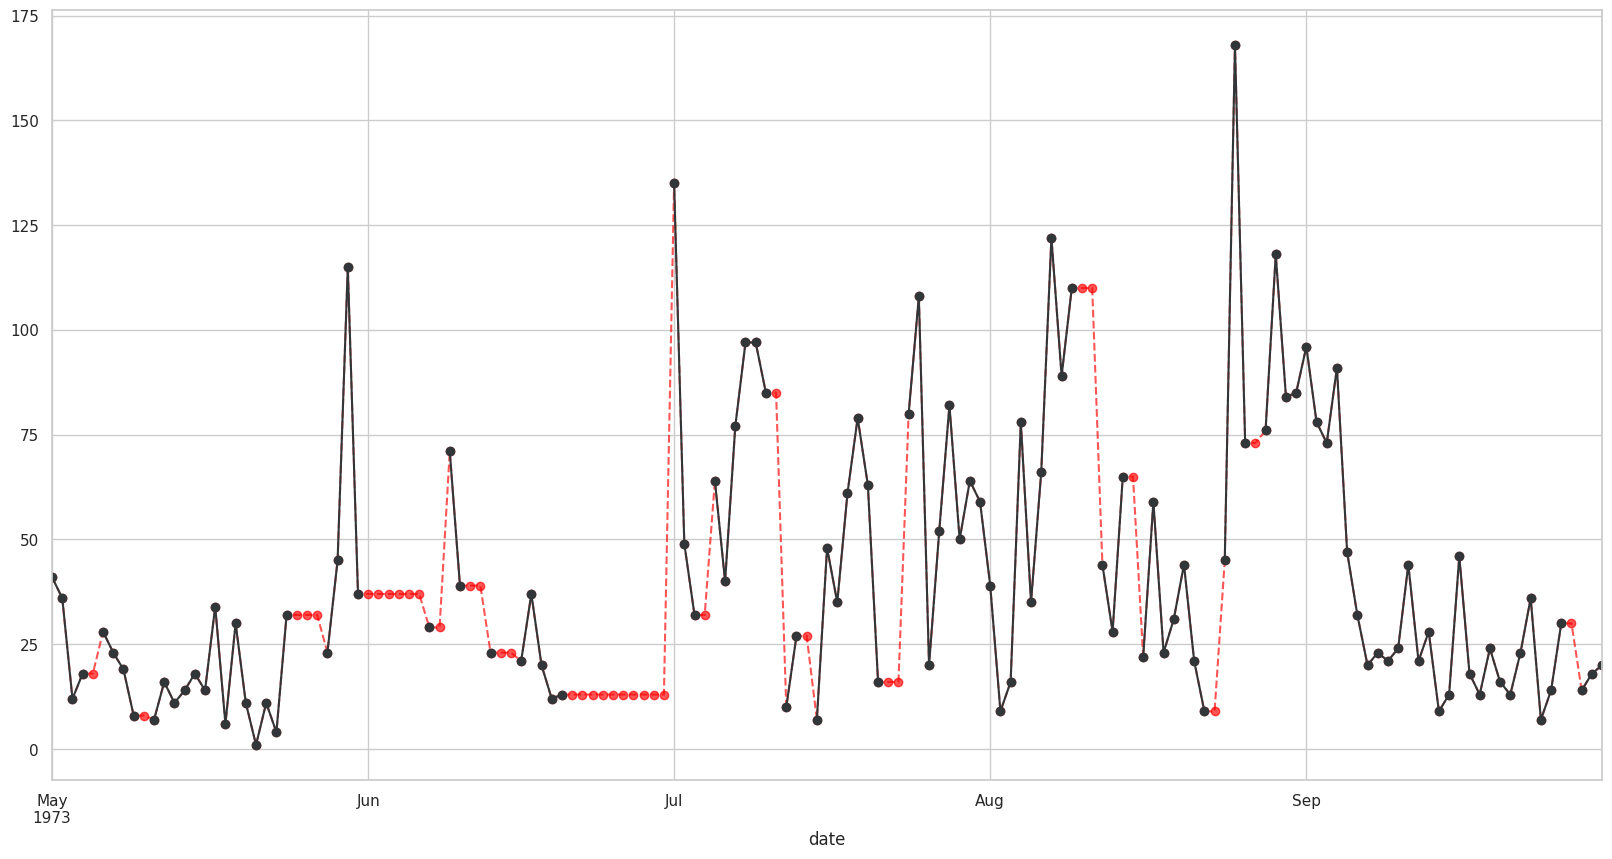

In [57]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color="red", marker="o", alpha=6/9, linestyle= "dashed"),
            df.ozone.plot(color="#313638", marker= "o")
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

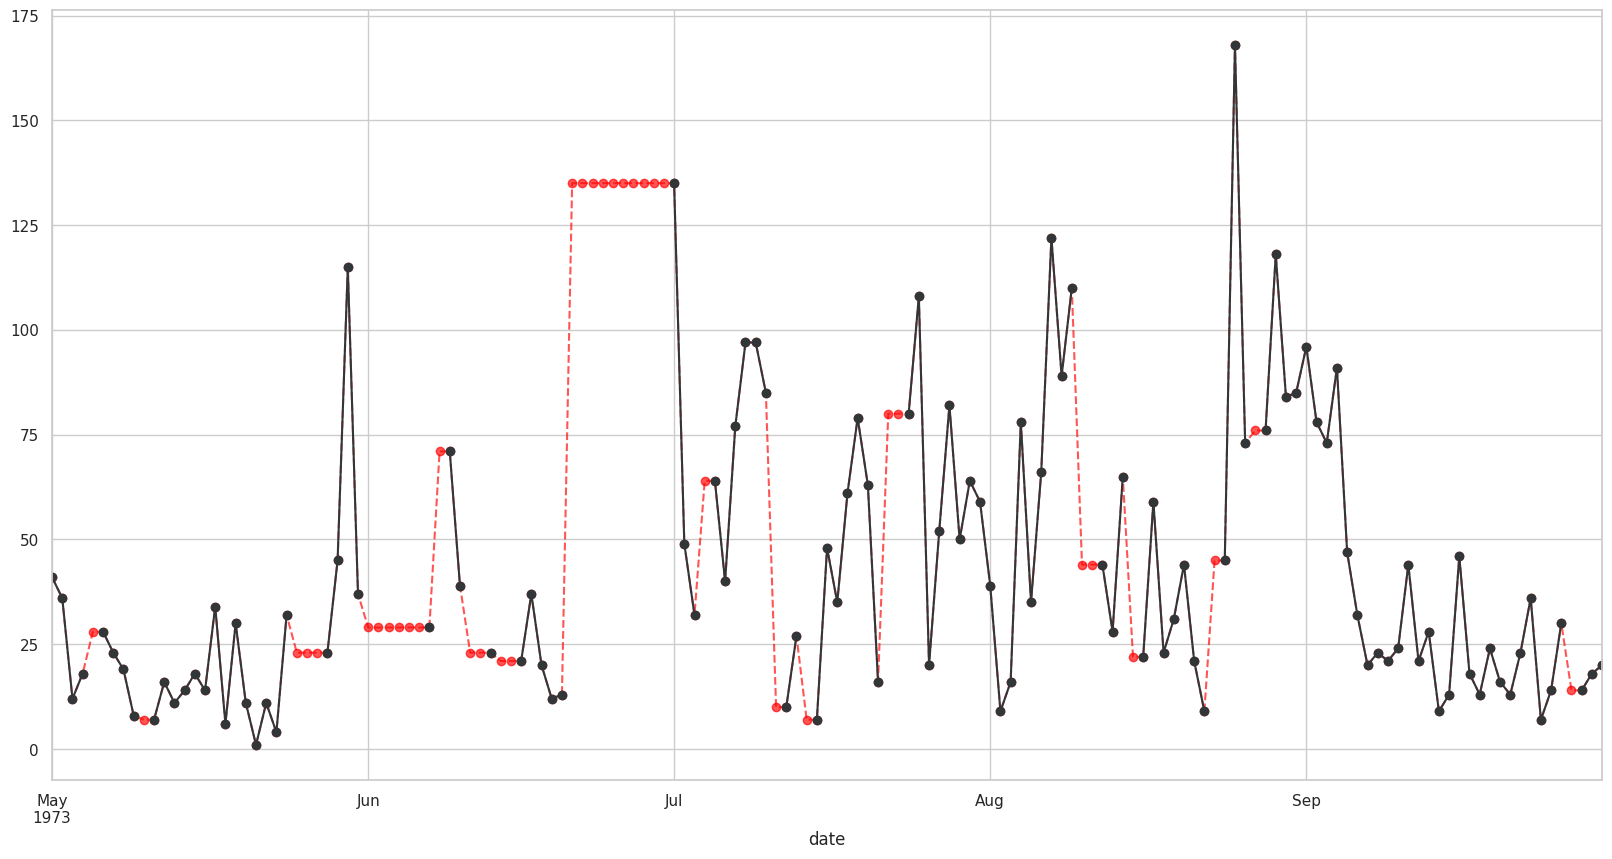

In [53]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color="red", marker="o", alpha=6/9, linestyle= "dashed"),
            df.ozone.plot(color="#313638", marker= "o")
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

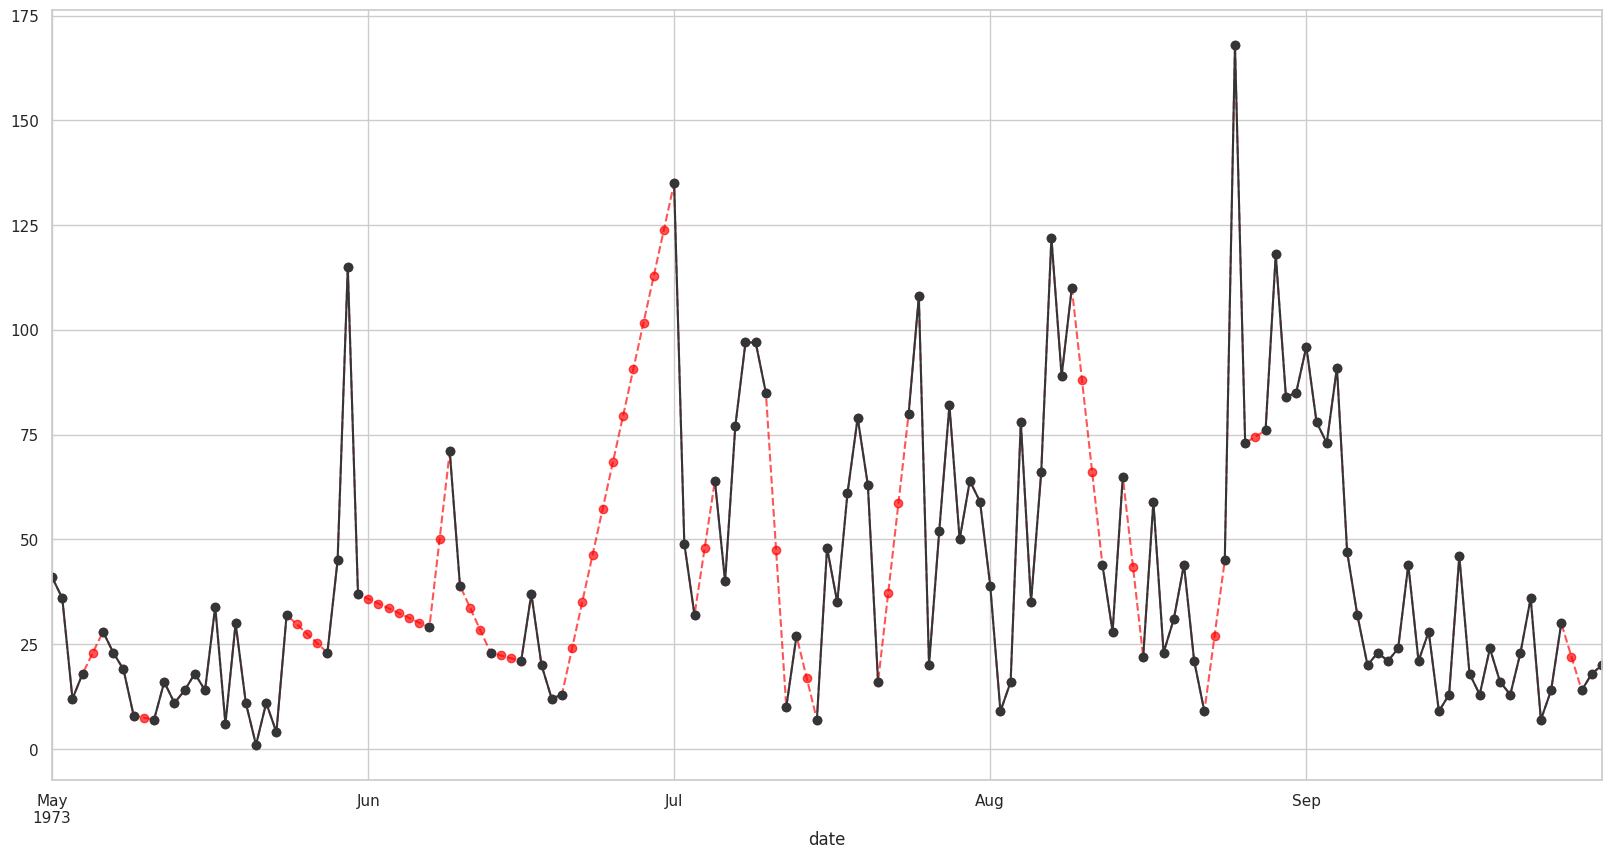

In [54]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method= "linear").plot(color="red", marker="o", alpha=6/9, linestyle= "dashed"),
            df.ozone.plot(color="#313638", marker= "o")
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

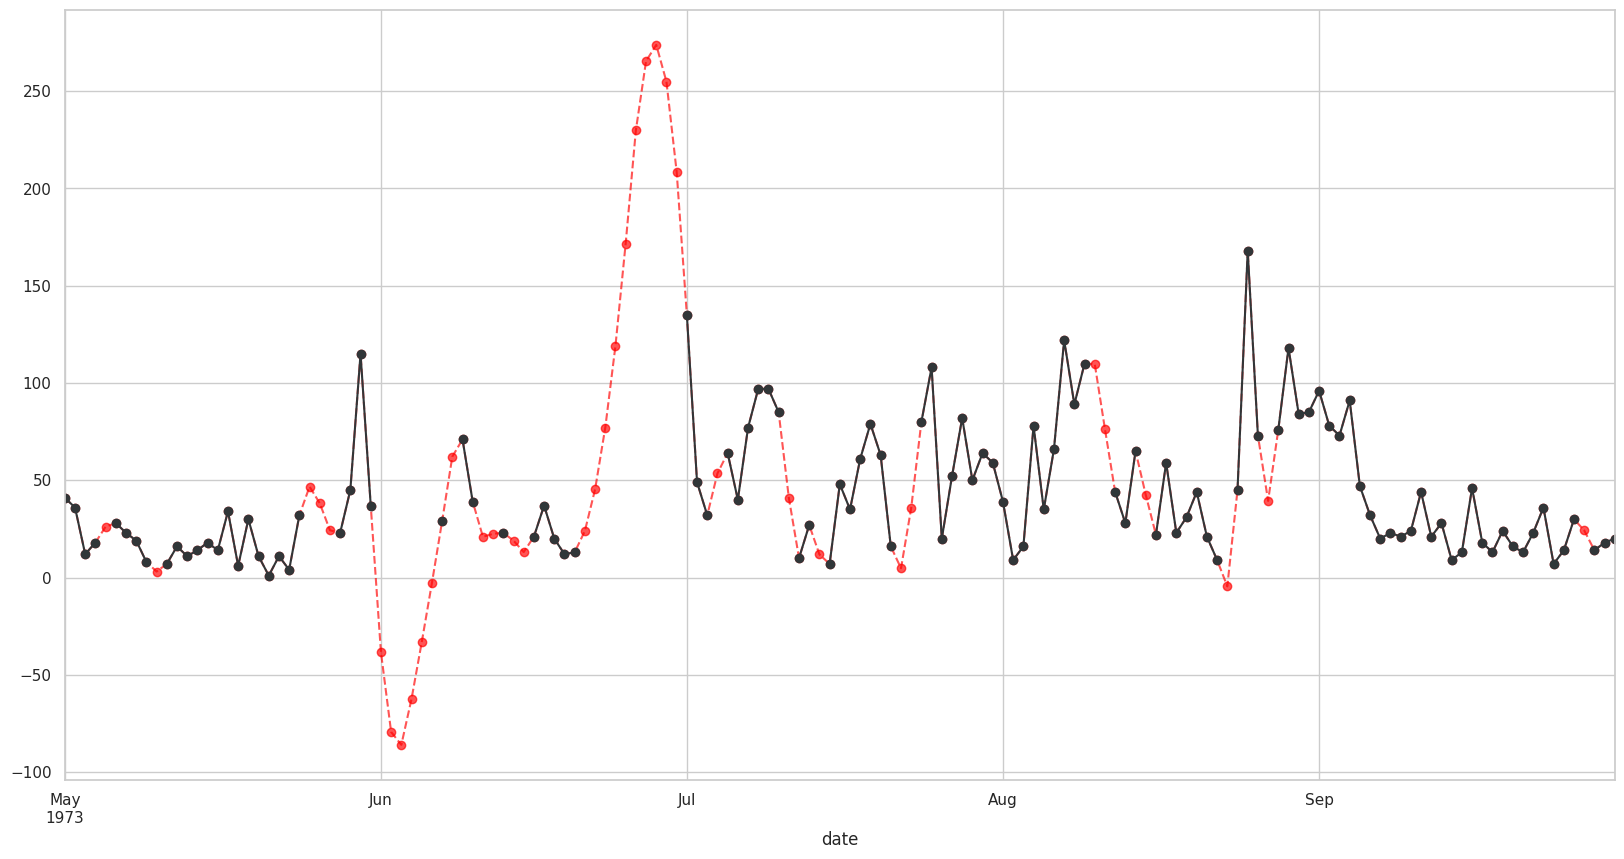

In [56]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method= "quadratic").plot(color="red", marker="o", alpha=6/9, linestyle= "dashed"),
            df.ozone.plot(color="#313638", marker= "o")
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

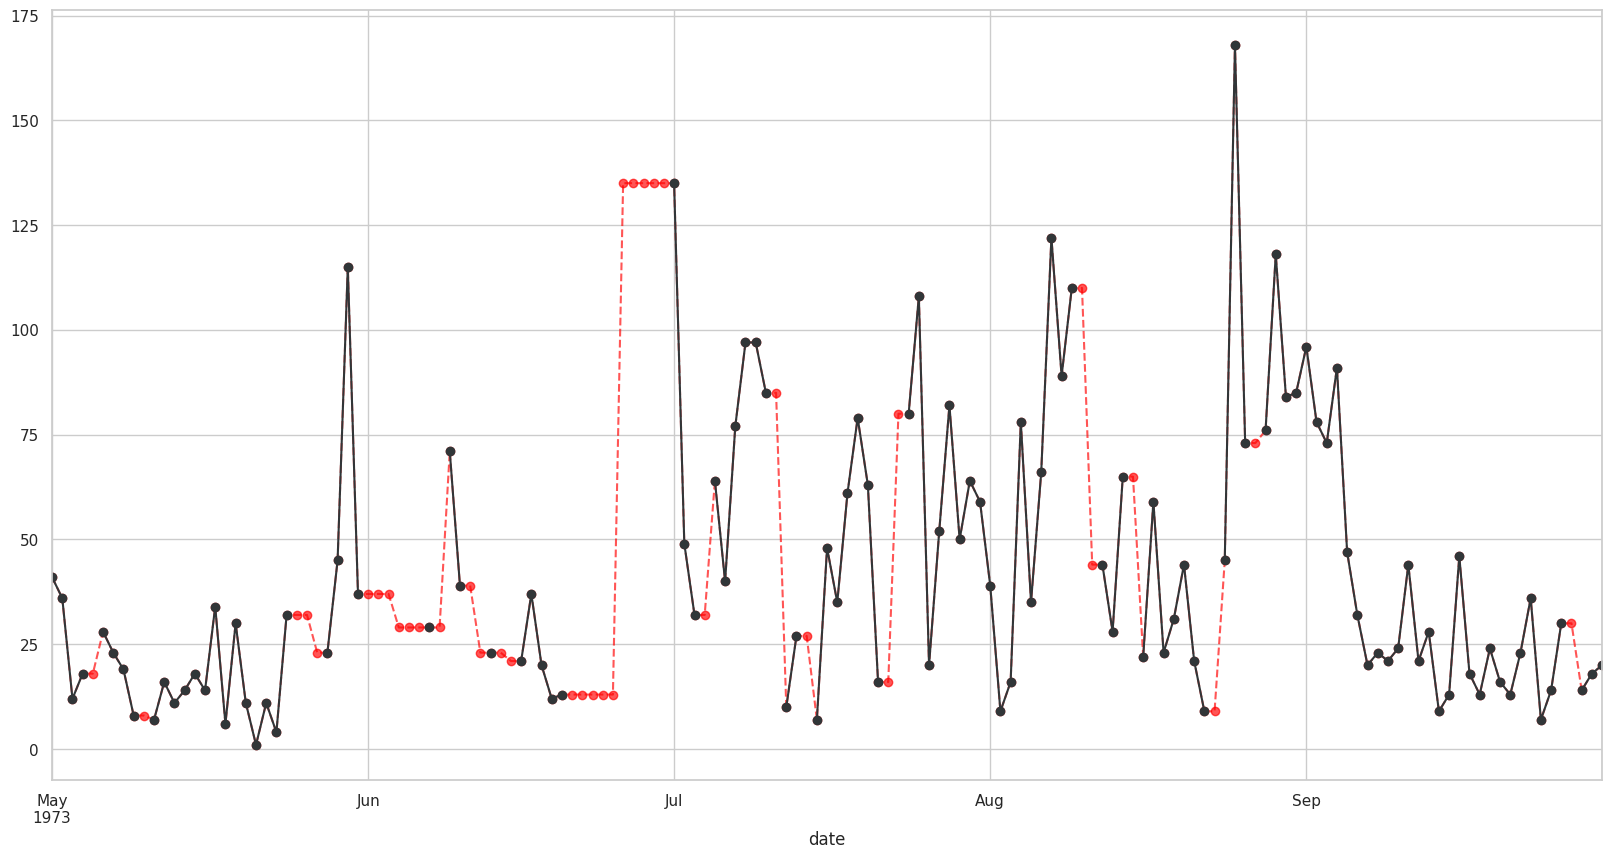

In [58]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method= "nearest").plot(color="red", marker="o", alpha=6/9, linestyle= "dashed"),
            df.ozone.plot(color="#313638", marker= "o")
        )
    )
)

In [59]:
airquality_df["ozone"] = airquality_df.ozone.interpolate(method="linear")

In [60]:
airquality_df["ozone"].isna().sum()

0

## Imputación por algoritmo de vecinos más cercanos (KNN)

### Ordenamiento por cantidad de variables faltantes

## Imputación basada en modelos

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

## Transformación inversa de los datos

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [ ]:
session_info.show()

/home/alphalejo/anaconda3/envs/missing_values/lib/python3.11/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>